In [1]:
import os
import sys
parent = os.path.abspath(os.path.join('./', os.pardir))
sys.path.insert(0, parent) # Add parent dirrectory to temporary path for imports
fontPath = os.path.abspath(os.path.join(parent,'UKNumberPlate.ttf'))

from nbp_helper_funs import *
from matplotlib import pyplot as plt

## Explanation

It currently takes a lot of time to generate the randomly distorted plate images for the bots to compete against. We thought that we could speed this up by using some of the code we've writte anyway. Here we try to figure out how to simulate the rotation of a 2D image in 3D space.

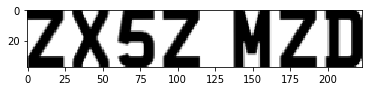

In [30]:
height =  int(60*45/71)
plate = pil2np(randomPlateImage(height, fontPath=fontPath))

h,w = plate.shape
plt.imshow(plate, cmap='gray')
plt.show()

In [198]:
angles = [0, np.pi/4, 0] # alpha, beta, gamma angles of rotation

c = list(np.cos(angle) for angle in angles)
s = list(np.sin(angle) for angle in angles)

# Three rotation matrices for three planes
R1 = np.matrix([[ c[0] , -s[0] ,  0    ,  0   ],
                [ s[0] ,  c[0] ,  0    ,  0   ],
                [ 0    ,  0    ,  1    ,  0   ],
                [ 0    ,  0    ,  0    ,  1   ]])

R2 = np.matrix([[ c[1] ,  0    , -s[1] ,  0   ],
                [ 0    ,  1    ,  0    ,  0   ],
                [ s[1] ,  0    ,  c[1] ,  0   ],
                [ 0    ,  0    ,  0    ,  1   ]])

R3 = np.matrix([[ 1    ,  0    ,  0    ,  0   ],
                [ 0    ,  c[2] , -s[2] ,  0   ],
                [ 0    ,  s[2] ,  c[2] ,  0   ],
                [ 0    ,  0    ,  0    ,  1   ]])

# Translation matrix
T  = np.matrix([[ 1    ,  0    ,  0    , -w/2 ],
                [ 0    ,  1    ,  0    , -h/2 ],
                [ 0    ,  0    ,  1    ,  0   ],
                [ 0    ,  0    ,  0    ,  1   ]])

# Projection matrix
s = 0.1 # Skew
P  = np.matrix([[ 1    ,  0    ,  s    ,  0   ],
                [ 0    ,  1    ,  s    ,  0   ]])

# Overall transformation matrix
# Move origin to center of the image, apply R1, R2 and R3, translate back and finally project
A = P*np.linalg.inv(T)*R3*R2*R1*T   

In [199]:
# Corners of the image
c = np.matrix([[0, 0, h, h],
               [0, w, w, 0],
               [0, 0, 0, 0],
               [1, 1, 1, 1]])
P

matrix([[ 1. ,  0. ,  0.1,  0. ],
        [ 0. ,  1. ,  0.1,  0. ]])

In [200]:
# Corners of the image
c = np.matrix([[0, 0, h, h],
               [0, w, w, 0],
               [0, 0, 0, 0],
               [1, 1, 1, 1]])

p1 = list(zip(*np.array(P*c)))
p2 = list(zip(*np.array(A*c)))
coeffs = getTransformCoeffs(p1,p2)
print(coeffs)

[  1.28564869e+00  -1.46589704e-14  -3.18498293e+01  -9.09090909e-02
   1.00000000e+00   1.01363636e+01   2.45788633e-16   1.02259855e-15]


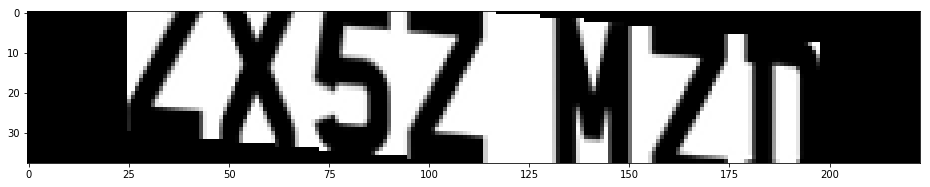

In [202]:
im = np2pil(plate)
coeffs = getTransformCoeffs(p1,p2)
im = im.transform((w,h), Image.PERSPECTIVE, coeffs, Image.BICUBIC)

plt.rcParams["figure.figsize"] = (16,5)
plt.imshow(pil2np(im), cmap='gray')
plt.show()